# Classification of Medial Entorhinal Units

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import scipy.signal as signal
import scipy.io as sio
import scipy as sp
import numpy as np
import math
import matplotlib.pyplot as plt
from find_grid_cells import load_data
from calculate_2d_tuning_curve import calculate_2d_tuning_curve
from calculate_spatial_periodicity import calculate_spatial_periodicity
from calculate_correlation_matrix import calculate_correlation_matrix
from fourier_transform import fourier_transform, analyze_fourier, analyze_polar_spectrogram, analyze_fourier_rings, fourier_rings_significance
from analyze_periodicity import analyze_periodicity, Partition_Data
from plot_data import plot_canonical_scoring_method, plot_analyze_correlation_periodicity, plot_fourier_scoring
from shuffle_rate_map import shuffle_rate_map

## The Medial Entorhinal Cortex
The [medial entorhinal cortex](http://www.scholarpedia.org/article/Entorhinal_cortex) (MEC) is an important structure for hippocampal – neocortical interactions and is thought to mediate the majority of bidirectional projections between the neocortex and the rest of the hippocampus. Anatomically, most of the neocortical projections to the hippocampus are relayed through the MEC superficial layers, whereas hippocampal output projections to the neocortex transit mostly in entorhinal cortex deep layers. Therefore, the superficial and deep layers of the MEC have been regarded as the input and output structures of the hippocampus, respectively. However, despite its important role in declarative memories, little is known about the memory processes that take place in the MEC.
<br><br>
<center>
<img src="images/mec-interface.png" style="height:180px" />
</center>

## Grid Cells
[Grid cells](http://www.scholarpedia.org/article/Grid_cells) are neurons in the MEC that are activated when the subject passes through multiple locations arranged in a hexagonal grid. Grid cells, along with other cells in the MEC such as head direction and speed cells, form circuits with place cells to create a comprehensive positioning system in the brain.
<br><br>
<center>
<img src="images/grid-cell.png" style="height:180px" />
</center>

Because the MEC accounts for initial position, head direction, and speed, it contains all the components necessary for path integration. The ability to classify cells in the MEC will then result in a better understanding of what navigational building blocks are important for memory processes. 
<br><br>
<center>
<img src="images/path-integration.png" style="height:180px" />
</center>

In [3]:
boxSize = 100
nPosBins = 20
filePath = './SargoliniMoser2006/11343-08120502_t8c2.mat'

files = ['11343-08120502_t8c2.mat', '11207-21060503_t8c1.mat']

posx1, posy1, t1, dt1, spiketrain1, smoothFiringRate1 = load_data('./SargoliniMoser2006/11343-08120502_t8c2.mat')
posx2, posy2, t2, dt2, spiketrain2, smoothFiringRate2 = load_data('./SargoliniMoser2006/11207-21060503_t8c1.mat')
# posx2, posy2, t2, dt2, spiketrain2, smoothFiringRate2 = load_data('./SargoliniMoser2006/11138-11040509_t5c1.mat')
# posx2, posy2, t2, dt2, spiketrain2, smoothFiringRate2 = load_data('./SargoliniMoser2006/11207-21060501+02_t6c1.mat')
# posx2, posy2, t2, dt2, spiketrain2, smoothFiringRate2 = load_data('./SargoliniMoser2006/11084-10030502_t1c2.mat')

# Calculates the unsmoothed and smoothed rate map
# Smoothed rate map used for correlation calculations, unsmoothed rate map used for fourier analysis
unsmoothRateMap1, smoothRateMap1 = calculate_2d_tuning_curve(posx1, posy1, smoothFiringRate1, nPosBins, 0, boxSize)
unsmoothRateMap2, smoothRateMap2 = calculate_2d_tuning_curve(posx2, posy2, smoothFiringRate2, nPosBins, 0, boxSize)

combineUnsmoothRateMap = unsmoothRateMap1 + unsmoothRateMap2

def gaussian_2d(shape=(3, 3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m, n = [(ss-1.)/2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

h = gaussian_2d()
combineSmoothRateMap = sp.ndimage.correlate(combineUnsmoothRateMap, h, mode='constant')

### Canonical Grid Scoring
Grid cells are typically scored by generating an autocorrelation matrix from the firing rate map, and then extracting a circular region defined by the 6 peaks around the central peak from the autocorrelation matrix. The circular region is then rotated in multiples of 30 degrees, and the correlation between the original and the rotated matrix is calculated with the following equation:

$$ r(\tau_x, \tau_y) = \frac{n \sum f(x,y) f(x-\tau_x, y-\tau_y) - \sum f(x,y) \sum f(x-\tau_x,y-\tau_y)}{\sqrt{n \sum f(x,y)^2 - \big( \sum f(x,y) \big)^2} \sqrt{n \sum f(x-\tau_x, y-\tau_y)^2 - \big( \sum f(x-\tau_x, y-\tau_y) \big)^2}}  $$

where $r(\tau_x, \tau_y)$ is the autocorrelation between bins with spatial offset $\tau_x$ and $\tau_y$. $f$ is the firing rate map of the cell with no smoothing applied; $n$ is the number of overlapping bins in two offset copies of the map. 

The grid score is then defined as the minimum difference between a peak (60° and 120°) and trough (30°, 90°, and 150°) of the correlation periodicity curve. Cells with a grid score greater than 0 are then identified as grid cells.
<br><br>
<center>
<p><center>Example Cell 1
<br>Grid Score: 1.158027
</center></p>
<table>
<tr>
<th><center>Rate Map</center></th>
<th><center>Autocorrelation Matrix</center></th>
<th><center>Circular Autocorrelation Region</center></th>
<th><center>Spactial Periodicity Curve</center></th>
</tr>
<tr>
<td><img src="images/grid-ratemap.png" /></td>
<td><img src="images/grid-autocorrelationmatrix.png" /></td>
<td><img src="images/grid-circularautocorrelation.png" /></td>
<td><img src="images/grid-periodicity.png" /></td>
</tr>
</table>

<p><center>
Example Cell 2
<br>Grid Score: 0.13359
</center></p>
<table>
<tr>
<th><center>Rate Map</center></th>
<th><center>Autocorrelation Matrix</center></th>
<th><center>Circular Autocorrelation Region</center></th>
<th><center>Spactial Periodicity Curve</center></th>
</tr>
<tr>
<td><img src="images/nongrid-ratemap.png" /></td>
<td><img src="images/nongrid-autocorrelationmatrix.png" /></td>
<td><img src="images/nongrid-circularautocorrelation.png" /></td>
<td><img src="images/nongrid-periodicity.png" /></td>
</tr>
</table>
</center>

However, this scoring method is limiting because it pre-defines grid cells as cells that fits this 60 degree rotational periodicity pattern and ignores all other types of periodic patterns; therefore, it is important to evaluate other methods for scoring and identifying MEC neurons. 

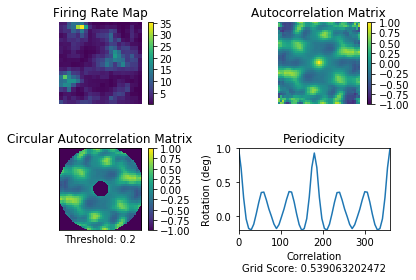

In [4]:
# Calculates the correlation matrix from the smooted rate map
correlationMatrix = calculate_correlation_matrix(combineSmoothRateMap)

# Determines the spatial periodicity of the correlation matrix by calculating the correlation of the 
# matrix in intervals of 6 degrees 
rotations, correlations, gridScore, circularMatrix, threshold = calculate_spatial_periodicity(correlationMatrix)

plot_canonical_scoring_method(combineSmoothRateMap, correlationMatrix, rotations, correlations, gridScore, circularMatrix, threshold)

### Analyzing Correlation Periodicity
To further analyze the periodicity of the correlation curves, the periodic distributions were transformed by separating the distribution into n partitions and then collapsing the n partitions. The correct period would yield a resulting circular distribution that is nonuniform and unimodal. However, if the distribution was transformed by an improper period, the resulting circular distribution will approach uniformity. 
<br><br>
<center>
<img src="images/collapse-periodicity.png" style="height:300px" />
</center>

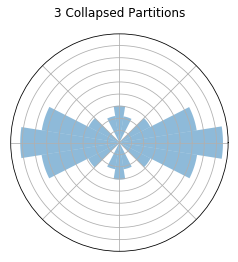

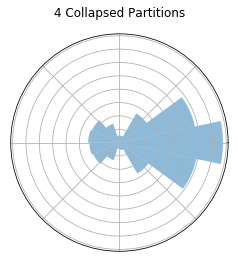

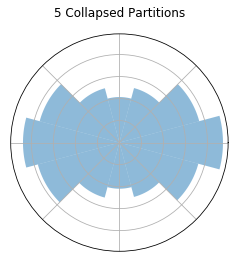

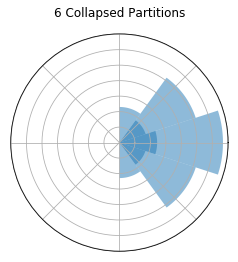

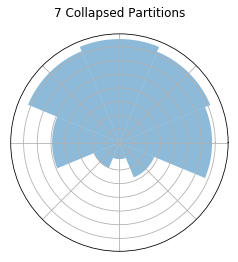

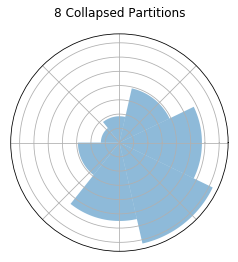

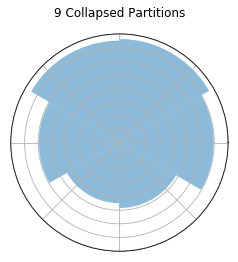

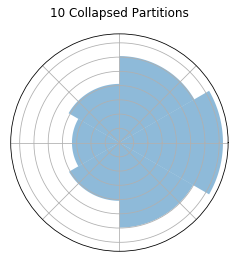

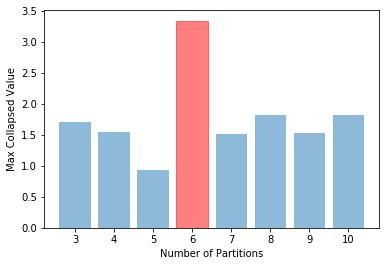

In [5]:
# Partitions the correlation periodicity curve into 3-10 periods and 
# collapses/sums the partitioned data 
collapsePartitionData, maxCollapseValues = analyze_periodicity(rotations, correlations)

plot_analyze_correlation_periodicity(collapsePartitionData, maxCollapseValues)

### Two-Dimensional Fourier Transformation Scoring
Two-dimensional Fourier transformations allow an image to be expressed by sinusoidal variations in brightness, and the sinusoidal pattern can be captured in a single Fourier term that encodes 1. the spatial frequency, 2. the magnitude (positive or negative), and 3. the phase. Below are some example images on the left and their respective two-dimensional Fourier transformation on the right.
<br><br>
<center>
<img src="images/fft1.png" style="height:150px" />
<img src="images/fft2.png" style="height:150px" />
<img src="images/fft3.png" style="height:150px" />
</center>

For an image with a periodic structure, the Fourier transformation will have peaks at spatial frequencies of repeated texture. Because of this property of Fourier transformation in identifying periodic structure, two-dimensional Fourier transformation can be used to more broadly identify periodicity in cell firing rate maps than the canonical scoring method. 
<br><br>
<center>
<table>
<tr>
<td><img src="images/periodic.png" style="height:150px" /></td>
<td><img src="images/periodicfft.png" style="height:150px" /></td>
</tr>
</table>
</center>

In order to estimate the degree of periodic regularity in the spatial distribution of cell firing, the two-dimensional Fourier spectrogram was calculated via the following equation:

$$ F[l_y, l_x] = \frac{1}{fr_{mean} \sqrt{M_x N_y}} \sum_{n=0}^{N-1} \sum_{m=0}^{M-1} f[m, n] e^{-2 \pi i \big( \frac{ml_y}{M} + \frac{nl_x}{N} \big)} $$

where $i = \sqrt{-1}$ and $f[m,n]$ is the unsmoothed firing rate map with mean firing rate subtracted and zero-padded to have size $M_x \times N_y = 256 \times 256$ to increase the spatial resolution of the Fourier spectrogram. The spectrogram is a matrix of Fourier coefficients corresponding to a basis set of plane waves of varying wavelength and orientation. Each plane wave is specified by the integer values $(l_y, l_x)$ which identify the y and x components of the wave vector in terms of the number of spatial cycles covering the entire firing rate map along its height and width respectively. $fr_{mean}$ is the mean firing rate. $M_x$ and $N_y$ are the width and lenght in bins of the original firing rate map before zero-padding. Division by $\sqrt{M_x N_y}$ enables comparison of Fourier power between firing rate maps from different size environments. Normalizing by mean firing rate enables comparison of cells with different firing rates.

The power of the Fourier spectrum is calculated as:

$$ P[l_y, l_x] = \sqrt{F_r^2[l_y, l_x] + F_i^2[l_y, l_x]} $$

where $F_r$ and $F_i$ are the real and the imaginary parts of the Fourier spectrum respectively. The maximum Fourier power $P[l_x, l_y]$ of the firing pattern was used to assess the degree of its spatial periodicity. 

Combined Fourier and Polar Spectrogram


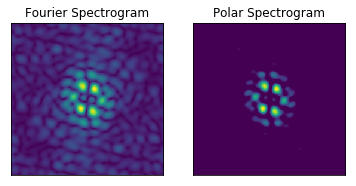

Cell 1 Fourier and Polar Spectrogram


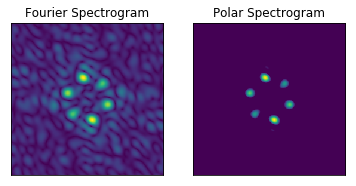

Cell 2 Fourier and Polar Spectrogram


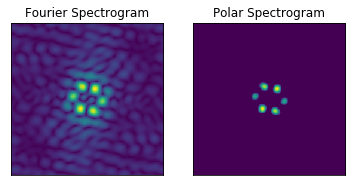

In [6]:
spiketrain1 = np.reshape(spiketrain1, (len(spiketrain1), 1))
spiketrain2 = np.reshape(spiketrain2, (len(spiketrain2), 1))
combineSpiketrain = np.vstack((spiketrain1, spiketrain2))

combinePosx = np.vstack((posx1, posx2))
combinePosy = np.vstack((posy1, posy2))

# Calculates the two-dimensional Fourier spectrogram
adjustedRateMap = combineUnsmoothRateMap - np.nanmean(combineUnsmoothRateMap)
meanFr = np.sum(combineSpiketrain) / (t1[-1] + t2[-1])
meanFr = meanFr[0]
fourierSpectrogram, polarSpectrogram, beforeMaxPower, maxPower, isPeriodic = fourier_transform(adjustedRateMap, meanFr, combineSpiketrain, dt1, combinePosx, combinePosy)

print('Combined Fourier and Polar Spectrogram')
plot_fourier_scoring(fourierSpectrogram, polarSpectrogram)

adjustedRateMap1 = unsmoothRateMap1 - np.nanmean(unsmoothRateMap1)
meanFr1 = np.sum(spiketrain1) / t1[-1]
meanFr1 = meanFr1[0]
fourierSpectrogram1, polarSpectrogram1, beforeMaxPower1, maxPower1, isPeriodic1 = fourier_transform(adjustedRateMap1, meanFr1, spiketrain1, dt1, posx1, posy1)

print('Cell 1 Fourier and Polar Spectrogram')
plot_fourier_scoring(fourierSpectrogram1, polarSpectrogram1)

adjustedRateMap2 = unsmoothRateMap2 - np.nanmean(unsmoothRateMap2)
meanFr2 = np.sum(spiketrain2) / t2[-1]
meanFr2 = meanFr2[0]
fourierSpectrogram2, polarSpectrogram2, beforeMaxPower2, maxPower2, isPeriodic2 = fourier_transform(adjustedRateMap2, meanFr2, spiketrain2, dt2, posx2, posy2)

print('Cell 2 Fourier and Polar Spectrogram')
plot_fourier_scoring(fourierSpectrogram2, polarSpectrogram2)

In [7]:
polarComponents = analyze_fourier(fourierSpectrogram, polarSpectrogram)

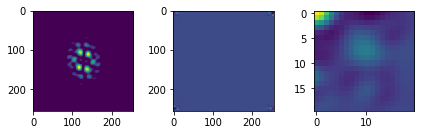

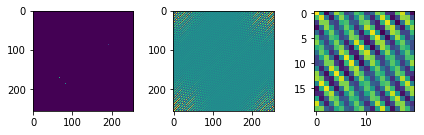

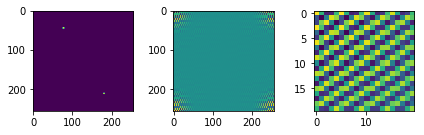

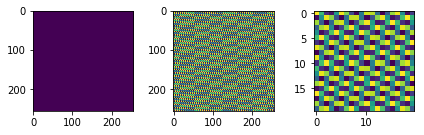

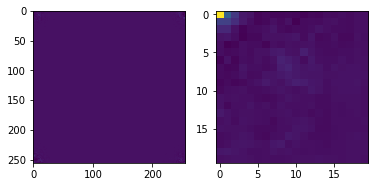

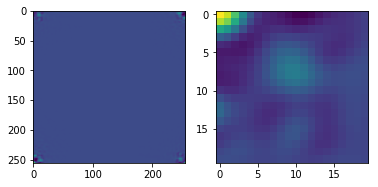

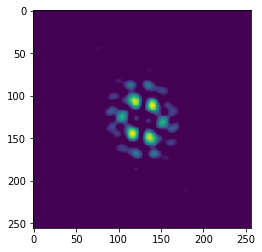

In [8]:
for i in range(polarComponents.shape[2]):
    component = polarComponents[:, :, i]
    inverseComponent = np.real(np.fft.ifft2(np.fft.ifftshift(component)))
        
    plt.subplot(1, 3, 1)
    plt.imshow(component)
        
    plt.subplot(1, 3, 2)
    plt.imshow(inverseComponent)
    
    plt.subplot(1, 3, 3)
    plt.imshow(inverseComponent[:20, :20])
        
    plt.tight_layout()
    plt.show()

inverseFourier = np.real(np.fft.ifft2(np.fft.ifftshift(fourierSpectrogram)))
plt.subplot(1, 2, 1)
plt.imshow(inverseFourier)
plt.subplot(1, 2, 2)
plt.imshow(inverseFourier[:20, :20])
plt.show()

inversePolar = np.real(np.fft.ifft2(np.fft.ifftshift(polarSpectrogram)))
plt.subplot(1, 2, 1)
plt.imshow(inversePolar)
plt.subplot(1, 2, 2)
plt.imshow(inversePolar[:20, :20])
plt.show()

polar = np.real(np.fft.fftshift(np.fft.fft2(inversePolar)))
plt.imshow(polar)
plt.show()

In [9]:
rhoMeanPower, localMaxima = analyze_polar_spectrogram(polarSpectrogram)
    
theta = (np.arange(360) * math.pi) / 180

theta2 = np.zeros(3*len(localMaxima))
theta2[::3] = localMaxima
theta2[1::3] = localMaxima
theta2[2::3] = localMaxima

rhos2 = np.zeros(3*len(localMaxima))
rhos2[1::3] = np.ones(len(localMaxima)) * math.ceil(max(rhoMeanPower))
  
plt.polar(theta, rhoMeanPower)
plt.polar(theta2, rhos2)
plt.show()

IndexError: index 14 is out of bounds for axis 0 with size 14

To further analyze the primary components of the Fourier spectrogram, the average power of cells within a defined annulus area of the spectrogram was calculated. This was done changing the length of the inner radius and keeping the area of the annulus constant.

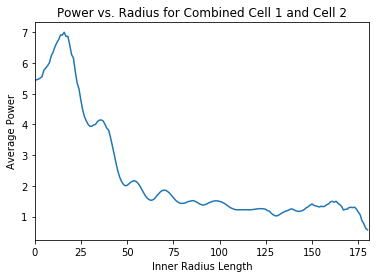

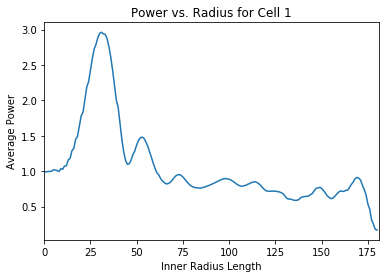

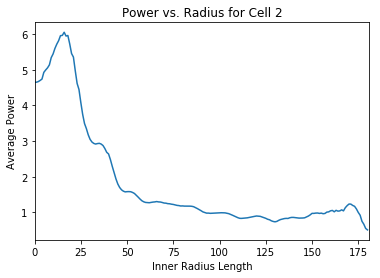

In [10]:
# Area of ring set to 1605 for a 256x256 matrix
area = 1605
averageRingPower, radii = analyze_fourier_rings(fourierSpectrogram, area)
    
plt.plot(radii, averageRingPower)
plt.title('Power vs. Radius for Combined Cell 1 and Cell 2')
plt.xlabel('Inner Radius Length')
plt.ylabel('Average Power')
maxRadius = math.floor(math.sqrt((fourierSpectrogram.shape[1]/2)**2 + (fourierSpectrogram.shape[0]/2)**2))
plt.xlim(0, maxRadius)
plt.show()

averageRingPower1, radii1 = analyze_fourier_rings(fourierSpectrogram1, 1605)

plt.plot(radii1, averageRingPower1)
plt.title('Power vs. Radius for Cell 1')
plt.xlabel('Inner Radius Length')
plt.ylabel('Average Power')
maxRadius1 = math.floor(math.sqrt((fourierSpectrogram1.shape[1]/2)**2 + (fourierSpectrogram1.shape[0]/2)**2))
plt.xlim(0, maxRadius1)
plt.show()

averageRingPower2, radii2 = analyze_fourier_rings(fourierSpectrogram2, 1605)
   
plt.plot(radii2, averageRingPower2)
plt.title('Power vs. Radius for Cell 2')
plt.xlabel('Inner Radius Length')
plt.ylabel('Average Power')
maxRadius2 = math.floor(math.sqrt((fourierSpectrogram2.shape[1]/2)**2 + (fourierSpectrogram2.shape[0]/2)**2))
plt.xlim(0, maxRadius2)
plt.show()

In order to identify significant components from the Fourier spectrogram, a random distribution was generated to compare against the average power distribution calculated above. A random distribution was generated by either: 1) shuffling the rate map in blocks of 1x1, 2x2, 4x4, and 5x5 pixels or 2) randomly shuffling the spiketrain.  

Random distribution with rate map shuffling with chunk size = 1


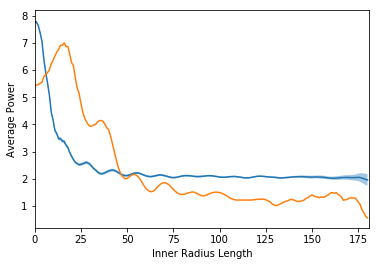

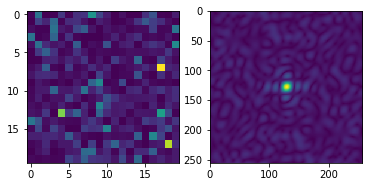

Random distribution with rate map shuffling with chunk size = 2


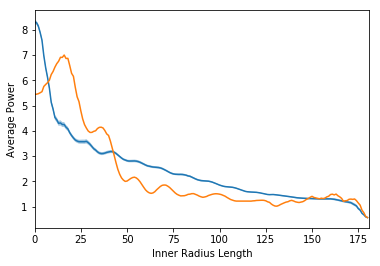

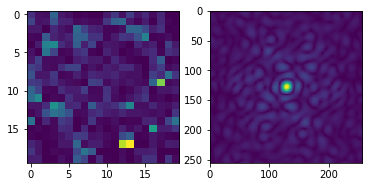

Random distribution with rate map shuffling with chunk size = 4


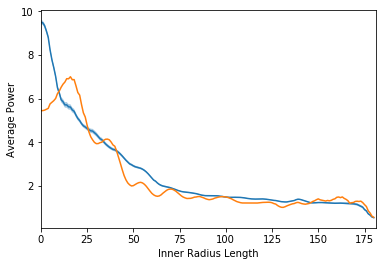

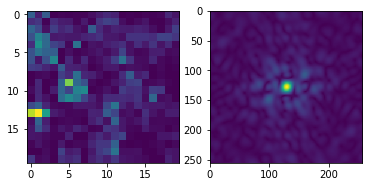

Random distribution with rate map shuffling with chunk size = 5


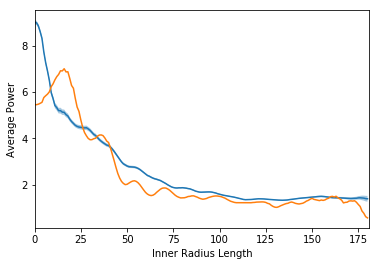

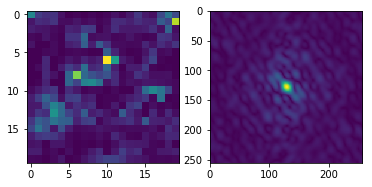

Random distribution with rate map shuffling with chunk size = 10


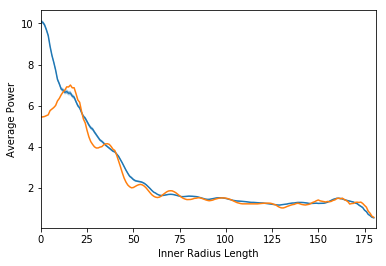

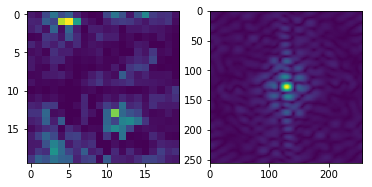

In [11]:
randomDistribution1, confidenceInterval, shuffleRateMap, shuffleFourier = fourier_rings_significance(combineUnsmoothRateMap, combineSpiketrain, t1, t2, dt1, combinePosx, combinePosy, 'rate map', 1)

print("Random distribution with rate map shuffling with chunk size = 1")
maxRadius = math.floor(math.sqrt((256/2)**2 + (256/2)**2))
radii = np.arange(0, maxRadius)
plt.plot(radii, randomDistribution1)
plt.plot(radii, averageRingPower)
ax = plt.gca()
ax.fill_between(radii, confidenceInterval[0], confidenceInterval[1], alpha=0.4)
plt.xlabel('Inner Radius Length')
plt.ylabel('Average Power')
plt.xlim(0, maxRadius)
plt.show()

plt.subplot(1, 2, 1)
plt.imshow(shuffleRateMap)
plt.subplot(1, 2, 2)
plt.imshow(shuffleFourier)
plt.show()

randomDistribution2, confidenceInterval, shuffleRateMap, shuffleFourier = fourier_rings_significance(combineUnsmoothRateMap, combineSpiketrain, t1, t2, dt1, combinePosx, combinePosy, 'rate map', 2)

print("Random distribution with rate map shuffling with chunk size = 2")
maxRadius = math.floor(math.sqrt((256/2)**2 + (256/2)**2))
radii = np.arange(0, maxRadius)
plt.plot(radii, randomDistribution2)
plt.plot(radii, averageRingPower)
ax = plt.gca()
ax.fill_between(radii, confidenceInterval[0], confidenceInterval[1], alpha=0.4)
plt.xlabel('Inner Radius Length')
plt.ylabel('Average Power')
plt.xlim(0, maxRadius)
plt.show()

plt.subplot(1, 2, 1)
plt.imshow(shuffleRateMap)
plt.subplot(1, 2, 2)
plt.imshow(shuffleFourier)
plt.show()

randomDistribution3, confidenceInterval, shuffleRateMap, shuffleFourier = fourier_rings_significance(combineUnsmoothRateMap, combineSpiketrain, t1, t2, dt1, combinePosx, combinePosy, 'rate map', 4)

print("Random distribution with rate map shuffling with chunk size = 4")
maxRadius = math.floor(math.sqrt((256/2)**2 + (256/2)**2))
radii = np.arange(0, maxRadius)
plt.plot(radii, randomDistribution3)
plt.plot(radii, averageRingPower)
ax = plt.gca()
ax.fill_between(radii, confidenceInterval[0], confidenceInterval[1], alpha=0.4)
plt.xlabel('Inner Radius Length')
plt.ylabel('Average Power')
plt.xlim(0, maxRadius)
plt.show()

plt.subplot(1, 2, 1)
plt.imshow(shuffleRateMap)
plt.subplot(1, 2, 2)
plt.imshow(shuffleFourier)
plt.show()

randomDistribution4, confidenceInterval, shuffleRateMap, shuffleFourier = fourier_rings_significance(combineUnsmoothRateMap, combineSpiketrain, t1, t2, dt1, combinePosx, combinePosy, 'rate map', 5)

print("Random distribution with rate map shuffling with chunk size = 5")
maxRadius = math.floor(math.sqrt((256/2)**2 + (256/2)**2))
radii = np.arange(0, maxRadius)
plt.plot(radii, randomDistribution4)
plt.plot(radii, averageRingPower)
ax = plt.gca()
ax.fill_between(radii, confidenceInterval[0], confidenceInterval[1], alpha=0.4)
plt.xlabel('Inner Radius Length')
plt.ylabel('Average Power')
plt.xlim(0, maxRadius)
plt.show()

plt.subplot(1, 2, 1)
plt.imshow(shuffleRateMap)
plt.subplot(1, 2, 2)
plt.imshow(shuffleFourier)
plt.show()

randomDistribution5, confidenceInterval, shuffleRateMap, shuffleFourier = fourier_rings_significance(combineUnsmoothRateMap, combineSpiketrain, t1, t2, dt1, combinePosx, combinePosy, 'rate map', 10)

print("Random distribution with rate map shuffling with chunk size = 10")
maxRadius = math.floor(math.sqrt((256/2)**2 + (256/2)**2))
radii = np.arange(0, maxRadius)
plt.plot(radii, randomDistribution5)
plt.plot(radii, averageRingPower)
ax = plt.gca()
ax.fill_between(radii, confidenceInterval[0], confidenceInterval[1], alpha=0.4)
plt.xlabel('Inner Radius Length')
plt.ylabel('Average Power')
plt.xlim(0, maxRadius)
plt.show()

plt.subplot(1, 2, 1)
plt.imshow(shuffleRateMap)
plt.subplot(1, 2, 2)
plt.imshow(shuffleFourier)
plt.show()

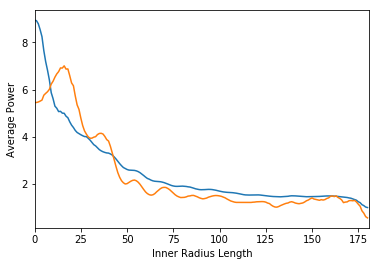

In [19]:
randomDistributionAverage = (randomDistribution1 + randomDistribution2 + randomDistribution3 + randomDistribution4 + randomDistribution5) / 5

maxRadius = math.floor(math.sqrt((256/2)**2 + (256/2)**2))
radii = np.arange(0, maxRadius)
plt.plot(radii, randomDistributionAverage)
plt.plot(radii, averageRingPower)
ax = plt.gca()
plt.xlabel('Inner Radius Length')
plt.ylabel('Average Power')
plt.xlim(0, maxRadius)
plt.show()

smooth = np.convolve(averageRingPower[:, 0], signal.gaussian(3, 1), mode='same')

localMaxima = signal.argrelextrema(smooth, np.greater)[0]
cont = True
i = 0
while cont:
    radius = localMaxima[i]
    if (averageRingPower[radius] <= randomDistribution[radius]):
        localMaxima = np.delete(localMaxima, i)
    else:
        i += 1
        
    if (i == len(localMaxima)):
        cont = False

Random distribution with spiketrain shuffling


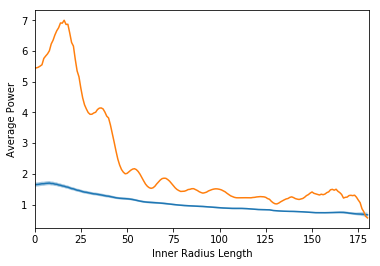

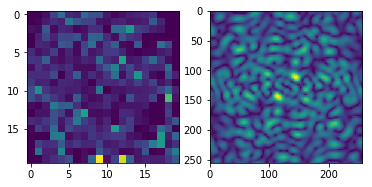

In [13]:
randomDistribution, confidenceInterval, shuffleRateMap, shuffleFourier = fourier_rings_significance(combineUnsmoothRateMap, combineSpiketrain, t1, t2, dt1, combinePosx, combinePosy, 'spiketrain')

print('Random distribution with spiketrain shuffling')
maxRadius = math.floor(math.sqrt((256/2)**2 + (256/2)**2))
radii = np.arange(0, maxRadius)
plt.plot(radii, randomDistribution)
plt.plot(radii, averageRingPower)
ax = plt.gca()
ax.fill_between(radii, confidenceInterval[0], confidenceInterval[1], alpha=0.4)
plt.xlabel('Inner Radius Length')
plt.ylabel('Average Power')
plt.xlim(0, maxRadius)
plt.show()

plt.subplot(1, 2, 1)
plt.imshow(shuffleRateMap)
plt.subplot(1, 2, 2)
plt.imshow(shuffleFourier)
plt.show()

Difference between average ring power and random distribution power


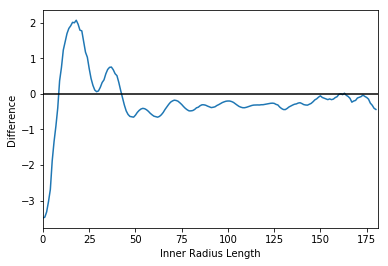

In [20]:
randomDistributionAverage = np.reshape(randomDistributionAverage, (len(randomDistributionAverage), 1))
difference = averageRingPower - randomDistributionAverage

print("Difference between average ring power and random distribution power")
plt.plot(radii, difference)
plt.xlabel('Inner Radius Length')
plt.ylabel('Difference')
plt.xlim(0, maxRadius)
plt.axhline(0, color='black')
plt.show()

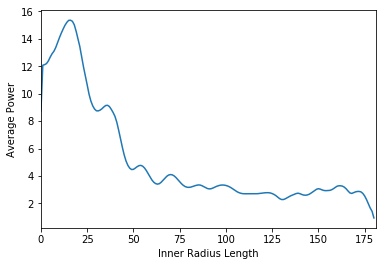

[ 16  36  54  70  85  98 113 122 139 150 161 172]


In [15]:
smooth = np.convolve(averageRingPower[:, 0], signal.gaussian(3, 1), mode='same')

plt.plot(radii, smooth)
ax = plt.gca()
plt.xlabel('Inner Radius Length')
plt.ylabel('Average Power')
plt.xlim(0, maxRadius)
plt.show()

localMaxima = signal.argrelextrema(smooth, np.greater)[0]
randomDistributionCITop = confidenceInterval[1, :]
cont = True
i = 0
while cont:
    radius = localMaxima[i]
    if (averageRingPower[radius] <= randomDistributionCITop[radius]):
        localMaxima = np.delete(localMaxima, i)
    else:
        i += 1
        
    if (i == len(localMaxima)):
        cont = False

print(localMaxima)

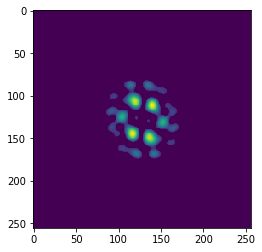

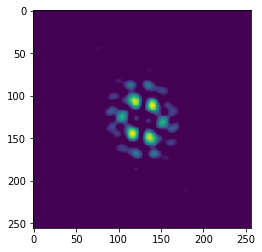

In [16]:
# figure out what main components does from original paper, line 63 of fourier_transform.py

mainComponents = np.copy(polarSpectrogram)
threshold = np.max(mainComponents) * 0.1
mainComponents[np.where(mainComponents < threshold)] = 0

plt.imshow(mainComponents)
plt.show()
plt.imshow(polarSpectrogram)
plt.show()